In [2]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=f7c93813796cffbc55572b79d8eeab4c3fe188bdd455e956ff8db032bde1240e
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [3]:
# Medical Text Summarization with Multiple Models
# Implements TextRank, BERTSUM, T5, BART, and PEGASUS
# Evaluates using ROUGE and BLEU scores
# ===============================================================

# Required Libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    BertTokenizer,
    EncoderDecoderModel,
    T5Tokenizer,
    T5ForConditionalGeneration,
    BartTokenizer,
    BartForConditionalGeneration,
    PegasusTokenizer,
    PegasusForConditionalGeneration
)
from rouge_score import rouge_scorer
import nltk.translate.bleu_score as bleu
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import time
import gc
from tqdm.notebook import tqdm

In [4]:
# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Set device - use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Using device: cuda


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [5]:
# Part 1: Data Loading and Preprocessing
# ===============================================================

def load_and_prepare_data(file_path, nrows=5000):
    """
    Load and prepare the MIMIC dataset for summarization

    Args:
        file_path: Path to the CSV file
        nrows: Number of rows to load

    Returns:
        DataFrame with preprocessed text
    """
    print(f"Loading {nrows} rows from the dataset...")
    df = pd.read_csv(file_path, nrows=nrows)
    print(f"Dataset loaded with shape: {df.shape}")

    # Handle missing values in text columns
    text_columns = ['AdmitDiagnosis', 'AdmitProcedure']
    for col in text_columns:
        if col in df.columns:
            df[col] = df[col].fillna('')

    # Create a combined text field
    df['combined_text'] = ''
    for col in text_columns:
        if col in df.columns:
            df['combined_text'] += df[col] + ' '

    # Remove extra spaces
    df['combined_text'] = df['combined_text'].str.strip()

    # Filter out empty or very short texts (less than 50 characters)
    df = df[df['combined_text'].str.len() > 50]

    # Reset index
    df.reset_index(drop=True, inplace=True)

    print(f"Prepared dataset with {len(df)} records")
    return df


In [6]:
# Part 2: Extractive Summarization Methods
# ===============================================================

class TextRankSummarizer:
    """Implements TextRank algorithm for extractive summarization"""

    def __init__(self):
        self.name = "TextRank"

    def summarize(self, text, ratio=0.3, min_length=40, max_length=None):
        """
        Summarize text using TextRank algorithm

        Args:
            text: Input text to summarize
            ratio: Ratio of sentences to keep
            min_length: Minimum character length for a sentence to be considered
            max_length: Maximum number of sentences in summary

        Returns:
            Summary text with key sentences
        """
        if pd.isna(text) or text.strip() == "":
            return ""

        # Tokenize the text into sentences
        sentences = sent_tokenize(text)

        # Filter very short sentences
        sentences = [s for s in sentences if len(s) >= min_length]

        # If there are too few sentences, return the original text
        if len(sentences) <= 2:
            return text

        # Calculate the number of sentences to select based on ratio
        num_sentences = max(2, int(len(sentences) * ratio))

        # If max_length is specified, limit the number of sentences
        if max_length is not None:
            num_sentences = min(num_sentences, max_length)

        # Create a TF-IDF vectorizer to convert sentences to vectors
        vectorizer = TfidfVectorizer(stop_words='english')

        try:
            # Transform sentences to TF-IDF vectors
            sentence_vectors = vectorizer.fit_transform(sentences)

            # Calculate similarity between all sentence pairs
            similarity_matrix = cosine_similarity(sentence_vectors)

            # Create a graph from the similarity matrix
            nx_graph = nx.from_numpy_array(similarity_matrix)

            # Apply PageRank algorithm
            scores = nx.pagerank(nx_graph)

            # Rank sentences based on scores
            ranked_sentences = sorted(((scores[i], i, sentence) for i, sentence in enumerate(sentences)),
                                     reverse=True)

            # Select top sentences
            top_indices = [idx for _, idx, _ in ranked_sentences[:num_sentences]]

            # Sort indices to maintain original order
            top_indices.sort()

            # Extract the sentences in their original order
            summary_sentences = [sentences[i] for i in top_indices]

            # Combine sentences into summary
            summary = ' '.join(summary_sentences)

            return summary

        except Exception as e:
            # Handle potential errors (e.g., empty vectors)
            print(f"Error in TextRank summarization: {e}")
            # Return a truncated version of original text as fallback
            return ' '.join(sentences[:num_sentences])

In [7]:
class BERTSummarizer:
    """Implements BERT-based extractive summarization"""

    def __init__(self):
        self.name = "BERTSUM"
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.model = EncoderDecoderModel.from_encoder_decoder_pretrained(
            'bert-base-uncased', 'bert-base-uncased'
        )
        self.model.to(device)

    def summarize(self, text, max_length=150):
        """
        Summarize text using BERT-based model

        Args:
            text: Input text to summarize
            max_length: Maximum length of summary in tokens

        Returns:
            Summarized text
        """
        if pd.isna(text) or text.strip() == "":
            return ""

        # Truncate input if it's too long for BERT (typically 512 tokens max)
        max_input_length = 512
        input_ids = self.tokenizer.encode(
            text, add_special_tokens=True, truncation=True, max_length=max_input_length
        )

        # If text is too short, return original
        if len(input_ids) < 10:
            return text

        # Convert to tensor and move to device
        input_tensor = torch.tensor([input_ids]).to(device)

        # Generate summary
        with torch.no_grad():
            outputs = self.model.generate(
                input_tensor,
                max_length=max_length,
                num_beams=4,
                early_stopping=True
            )

        # Decode and return summary
        summary = self.tokenizer.decode(outputs[0], skip_special_tokens=True)

        return summary

    def save(self, path="models/bert_summarizer"):
        """Save the model and tokenizer"""
        os.makedirs(path, exist_ok=True)
        self.model.save_pretrained(path)
        self.tokenizer.save_pretrained(path)
        print(f"BERTSUM model saved to {path}")

    def load(self, path="models/bert_summarizer"):
        """Load the model and tokenizer"""
        self.model = EncoderDecoderModel.from_pretrained(path)
        self.tokenizer = BertTokenizer.from_pretrained(path)
        self.model.to(device)
        print(f"BERTSUM model loaded from {path}")

In [8]:
# Part 3: Abstractive Summarization Methods
# ===============================================================

class T5Summarizer:
    """Implements T5-based abstractive summarization"""

    def __init__(self, model_name="t5-small"):
        self.name = "T5"
        self.model_name = model_name
        self.tokenizer = T5Tokenizer.from_pretrained(model_name)
        self.model = T5ForConditionalGeneration.from_pretrained(model_name)
        self.model.to(device)

    def summarize(self, text, max_length=150, min_length=40):
        """
        Summarize text using T5 model

        Args:
            text: Input text to summarize
            max_length: Maximum length of summary in tokens
            min_length: Minimum length of summary in tokens

        Returns:
            Summarized text
        """
        if pd.isna(text) or text.strip() == "":
            return ""

        # T5 requires a "summarize: " prefix for summarization task
        text = "summarize: " + text

        # Truncate input if needed (T5-small can handle ~512 tokens)
        max_input_length = 512

        # Encode the text
        input_ids = self.tokenizer.encode(
            text, return_tensors="pt", truncation=True, max_length=max_input_length
        ).to(device)

        # Generate summary
        with torch.no_grad():
            summary_ids = self.model.generate(
                input_ids,
                max_length=max_length,
                min_length=min_length,
                num_beams=4,
                no_repeat_ngram_size=2,
                early_stopping=True
            )

        # Decode summary
        summary = self.tokenizer.decode(summary_ids[0], skip_special_tokens=True)

        return summary

    def save(self, path="models/t5_summarizer"):
        """Save the model and tokenizer"""
        os.makedirs(path, exist_ok=True)
        self.model.save_pretrained(path)
        self.tokenizer.save_pretrained(path)
        print(f"T5 model saved to {path}")

    def load(self, path="models/t5_summarizer"):
        """Load the model and tokenizer"""
        self.model = T5ForConditionalGeneration.from_pretrained(path)
        self.tokenizer = T5Tokenizer.from_pretrained(path)
        self.model.to(device)
        print(f"T5 model loaded from {path}")

In [9]:
class BARTSummarizer:
    """Implements BART-based abstractive summarization"""

    def __init__(self, model_name="facebook/bart-base"):
        self.name = "BART"
        self.model_name = model_name
        self.tokenizer = BartTokenizer.from_pretrained(model_name)
        self.model = BartForConditionalGeneration.from_pretrained(model_name)
        self.model.to(device)

    def summarize(self, text, max_length=150, min_length=40):
        """
        Summarize text using BART model

        Args:
            text: Input text to summarize
            max_length: Maximum length of summary in tokens
            min_length: Minimum length of summary in tokens

        Returns:
            Summarized text
        """
        if pd.isna(text) or text.strip() == "":
            return ""

        # Truncate input if needed (BART can handle ~1024 tokens)
        max_input_length = 1024

        # Encode the text
        input_ids = self.tokenizer.encode(
            text, return_tensors="pt", truncation=True, max_length=max_input_length
        ).to(device)

        # Generate summary
        with torch.no_grad():
            summary_ids = self.model.generate(
                input_ids,
                max_length=max_length,
                min_length=min_length,
                num_beams=4,
                no_repeat_ngram_size=2,
                early_stopping=True
            )

        # Decode summary
        summary = self.tokenizer.decode(summary_ids[0], skip_special_tokens=True)

        return summary

    def save(self, path="models/bart_summarizer"):
        """Save the model and tokenizer"""
        os.makedirs(path, exist_ok=True)
        self.model.save_pretrained(path)
        self.tokenizer.save_pretrained(path)
        print(f"BART model saved to {path}")

    def load(self, path="models/bart_summarizer"):
        """Load the model and tokenizer"""
        self.model = BartForConditionalGeneration.from_pretrained(path)
        self.tokenizer = BartTokenizer.from_pretrained(path)
        self.model.to(device)
        print(f"BART model loaded from {path}")

In [10]:
class PEGASUSSummarizer:
    """Implements PEGASUS-based abstractive summarization"""

    def __init__(self, model_name="google/pegasus-xsum"):
        self.name = "PEGASUS"
        self.model_name = model_name
        self.tokenizer = PegasusTokenizer.from_pretrained(model_name)
        self.model = PegasusForConditionalGeneration.from_pretrained(model_name)
        self.model.to(device)

    def summarize(self, text, max_length=150, min_length=40):
        """
        Summarize text using PEGASUS model

        Args:
            text: Input text to summarize
            max_length: Maximum length of summary in tokens
            min_length: Minimum length of summary in tokens

        Returns:
            Summarized text
        """
        if pd.isna(text) or text.strip() == "":
            return ""

        # Truncate input if needed (PEGASUS can handle ~1024 tokens)
        max_input_length = 1024

        # Encode the text
        input_ids = self.tokenizer.encode(
            text, return_tensors="pt", truncation=True, max_length=max_input_length
        ).to(device)

        # Generate summary
        with torch.no_grad():
            summary_ids = self.model.generate(
                input_ids,
                max_length=max_length,
                min_length=min_length,
                num_beams=4,
                no_repeat_ngram_size=2,
                early_stopping=True
            )

        # Decode summary
        summary = self.tokenizer.decode(summary_ids[0], skip_special_tokens=True)

        return summary

    def save(self, path="models/pegasus_summarizer"):
        """Save the model and tokenizer"""
        os.makedirs(path, exist_ok=True)
        self.model.save_pretrained(path)
        self.tokenizer.save_pretrained(path)
        print(f"PEGASUS model saved to {path}")

    def load(self, path="models/pegasus_summarizer"):
        """Load the model and tokenizer"""
        self.model = PegasusForConditionalGeneration.from_pretrained(path)
        self.tokenizer = PegasusTokenizer.from_pretrained(path)
        self.model.to(device)
        print(f"PEGASUS model loaded from {path}")

In [11]:
# Part 4: Evaluation Metrics
# ===============================================================

class SummaryEvaluator:
    """Evaluates summarization quality using ROUGE and BLEU scores"""

    def __init__(self):
        # Initialize ROUGE scorer with different variants
        self.rouge_scorer = rouge_scorer.RougeScorer(
            ['rouge1', 'rouge2', 'rougeL'], use_stemmer=True
        )

    def evaluate_rouge(self, reference, summary):
        """
        Evaluate summary using ROUGE metrics

        Args:
            reference: Reference text (original)
            summary: Generated summary

        Returns:
            Dictionary of ROUGE scores
        """
        if pd.isna(reference) or pd.isna(summary) or reference.strip() == "" or summary.strip() == "":
            return {
                'rouge1_f': 0.0,
                'rouge1_p': 0.0,
                'rouge1_r': 0.0,
                'rouge2_f': 0.0,
                'rouge2_p': 0.0,
                'rouge2_r': 0.0,
                'rougeL_f': 0.0,
                'rougeL_p': 0.0,
                'rougeL_r': 0.0
            }

        # Calculate ROUGE scores
        scores = self.rouge_scorer.score(reference, summary)

        # Extract F1, precision, and recall for each ROUGE variant
        rouge_scores = {
            'rouge1_f': scores['rouge1'].fmeasure,
            'rouge1_p': scores['rouge1'].precision,
            'rouge1_r': scores['rouge1'].recall,
            'rouge2_f': scores['rouge2'].fmeasure,
            'rouge2_p': scores['rouge2'].precision,
            'rouge2_r': scores['rouge2'].recall,
            'rougeL_f': scores['rougeL'].fmeasure,
            'rougeL_p': scores['rougeL'].precision,
            'rougeL_r': scores['rougeL'].recall
        }

        return rouge_scores

    def evaluate_bleu(self, reference, summary):
        """
        Evaluate summary using BLEU score

        Args:
            reference: Reference text (original)
            summary: Generated summary

        Returns:
            BLEU score
        """
        if pd.isna(reference) or pd.isna(summary) or reference.strip() == "" or summary.strip() == "":
            return 0.0

        # Tokenize reference and summary
        reference_tokens = word_tokenize(reference.lower())
        summary_tokens = word_tokenize(summary.lower())

        # Calculate BLEU score
        try:
            return bleu.sentence_bleu([reference_tokens], summary_tokens, weights=(0.25, 0.25, 0.25, 0.25))
        except Exception as e:
            print(f"Error calculating BLEU score: {e}")
            return 0.0

    def evaluate_summary(self, reference, summary):
        """
        Evaluate summary using all metrics

        Args:
            reference: Reference text (original)
            summary: Generated summary

        Returns:
            Dictionary of all scores
        """
        rouge_scores = self.evaluate_rouge(reference, summary)
        bleu_score = self.evaluate_bleu(reference, summary)

        scores = {
            'bleu': bleu_score,
            **rouge_scores
        }

        return scores


In [12]:
# Part 5: Running and Evaluating All Summarizers
# ===============================================================

def generate_and_evaluate_summaries(df, text_column='combined_text', sample_size=None,
                                   save_dir='models'):
    """
    Generate and evaluate summaries using all summarization methods

    Args:
        df: DataFrame with text data
        text_column: Column containing text to summarize
        sample_size: Number of samples to process (None for all)
        save_dir: Directory to save models

    Returns:
        DataFrame with all summaries and evaluation metrics
    """
    # Create save directory
    os.makedirs(save_dir, exist_ok=True)

    # Take a sample if specified
    if sample_size is not None and sample_size < len(df):
        sample_df = df.sample(sample_size, random_state=42)
    else:
        sample_df = df

    print(f"Generating summaries for {len(sample_df)} records")

    # Initialize summarizers
    summarizers = [
        TextRankSummarizer(),
        BERTSummarizer(),
        T5Summarizer(),
        BARTSummarizer(),
        PEGASUSSummarizer()
    ]

    # Initialize evaluator
    evaluator = SummaryEvaluator()

    # Create a results DataFrame
    results_df = pd.DataFrame()
    results_df['original_text'] = sample_df[text_column]

    # Create columns for summaries and metrics
    for summarizer in summarizers:
        results_df[f'{summarizer.name}_summary'] = ''
        results_df[f'{summarizer.name}_bleu'] = 0.0
        results_df[f'{summarizer.name}_rouge1_f'] = 0.0
        results_df[f'{summarizer.name}_rouge2_f'] = 0.0
        results_df[f'{summarizer.name}_rougeL_f'] = 0.0

    # Set a batch size for processing to avoid memory issues
    batch_size = 10
    num_batches = (len(sample_df) + batch_size - 1) // batch_size

    # Process each summarizer
    for summarizer in summarizers:
        print(f"\nGenerating summaries using {summarizer.name}...")

        # Process in batches
        for batch_idx in tqdm(range(num_batches)):
            start_idx = batch_idx * batch_size
            end_idx = min((batch_idx + 1) * batch_size, len(sample_df))
            batch_indices = sample_df.index[start_idx:end_idx]

            # Generate summaries for this batch
            for idx in batch_indices:
                text = sample_df.loc[idx, text_column]

                # Generate summary
                try:
                    summary = summarizer.summarize(text)

                    # Evaluate summary
                    scores = evaluator.evaluate_summary(text, summary)

                    # Store results in the DataFrame
                    results_df.loc[idx, f'{summarizer.name}_summary'] = summary
                    results_df.loc[idx, f'{summarizer.name}_bleu'] = scores['bleu']
                    results_df.loc[idx, f'{summarizer.name}_rouge1_f'] = scores['rouge1_f']
                    results_df.loc[idx, f'{summarizer.name}_rouge2_f'] = scores['rouge2_f']
                    results_df.loc[idx, f'{summarizer.name}_rougeL_f'] = scores['rougeL_f']

                except Exception as e:
                    print(f"Error processing record {idx} with {summarizer.name}: {e}")

            # Save models after each batch for deep learning models
            if hasattr(summarizer, 'save') and batch_idx % 5 == 0:
                try:
                    summarizer.save(f"{save_dir}/{summarizer.name.lower()}_summarizer")
                except Exception as e:
                    print(f"Error saving {summarizer.name} model: {e}")

            # Clear GPU memory
            torch.cuda.empty_cache()
            gc.collect()

    # Final model saves
    for summarizer in summarizers:
        if hasattr(summarizer, 'save'):
            try:
                summarizer.save(f"{save_dir}/{summarizer.name.lower()}_summarizer")
            except Exception as e:
                print(f"Error saving {summarizer.name} model: {e}")

    # Save results DataFrame
    results_file = f"{save_dir}/summarization_results.csv"
    results_df.to_csv(results_file, index=False)
    print(f"Results saved to {results_file}")

    return results_df

In [13]:
# Part 6: Analysis and Visualization
# ===============================================================

def analyze_summarization_results(results_df):
    """
    Analyze and visualize summarization results

    Args:
        results_df: DataFrame with summarization results

    Returns:
        None (displays visualizations)
    """
    # Calculate average scores for each model
    summarizers = ['TextRank', 'BERTSUM', 'T5', 'BART', 'PEGASUS']
    metrics = ['bleu', 'rouge1_f', 'rouge2_f', 'rougeL_f']

    avg_scores = {}
    for summarizer in summarizers:
        avg_scores[summarizer] = {}
        for metric in metrics:
            col_name = f'{summarizer}_{metric}'
            if col_name in results_df.columns:
                avg_scores[summarizer][metric] = results_df[col_name].mean()
            else:
                avg_scores[summarizer][metric] = 0.0

    # Create a DataFrame for visualization
    scores_df = pd.DataFrame(avg_scores).T

    # Visualize ROUGE-1 F1 scores
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=scores_df.index, y=scores_df['rouge1_f'])
    ax.set_title('Average ROUGE-1 F1 Score by Summarizer')
    ax.set_xlabel('Summarizer')
    ax.set_ylabel('ROUGE-1 F1 Score')

    # Add value labels
    for i, v in enumerate(scores_df['rouge1_f']):
        ax.text(i, v + 0.01, f'{v:.3f}', ha='center')

    plt.tight_layout()
    plt.show()

    # Visualize all metrics
    plt.figure(figsize=(15, 8))
    scores_df_melted = scores_df.reset_index().melt(
        id_vars='index', var_name='Metric', value_name='Score'
    )

    ax = sns.barplot(x='index', y='Score', hue='Metric', data=scores_df_melted)
    ax.set_title('Summarization Performance Across All Metrics')
    ax.set_xlabel('Summarizer')
    ax.set_ylabel('Score')
    ax.legend(title='Metric')

    plt.tight_layout()
    plt.show()

    # Visualize summary length distribution
    plt.figure(figsize=(15, 8))

    summary_lengths = {}
    for summarizer in summarizers:
        col_name = f'{summarizer}_summary'
        if col_name in results_df.columns:
            summary_lengths[summarizer] = results_df[col_name].str.len()

    summary_length_df = pd.DataFrame(summary_lengths)

    ax = sns.boxplot(data=summary_length_df)
    ax.set_title('Summary Length Distribution by Summarizer')
    ax.set_xlabel('Summarizer')
    ax.set_ylabel('Summary Length (characters)')

    plt.tight_layout()
    plt.show()

    # Print detailed metrics
    print("Average Performance Metrics:")
    print(scores_df.round(4))

    return scores_df

# Part 7: Streamlit Model Preparation
# ===============================================================

def prepare_models_for_streamlit(save_dir='models'):
    """
    Prepare models for use in a Streamlit app

    Args:
        save_dir: Directory where models are saved

    Returns:
        None
    """
    # Create a dictionary with model configuration
    model_config = {
        'TextRank': {
            'type': 'statistical',
            'requires_download': False
        },
        'BERTSUM': {
            'type': 'transformer',
            'model_path': f"{save_dir}/bertsum_summarizer",
            'requires_download': True
        },
        'T5': {
            'type': 'transformer',
            'model_path': f"{save_dir}/t5_summarizer",
            'requires_download': True
        },
        'BART': {
            'type': 'transformer',
            'model_path': f"{save_dir}/bart_summarizer",
            'requires_download': True
        },
        'PEGASUS': {
            'type': 'transformer',
            'model_path': f"{save_dir}/pegasus_summarizer",
            'requires_download': True
        }
    }

    # Save configuration
    config_file = f"{save_dir}/model_config.pkl"
    with open(config_file, 'wb') as f:
        pickle.dump(model_config, f)

    print(f"Model configuration saved to {config_file}")

    # Create a simple README for the Streamlit app
    readme = f"""# Medical Blog Summarization Models

This folder contains trained summarization models for medical blog generation.

## Available Models:
- TextRank (Statistical approach)
- BERTSUM (BERT-based extractive summarization)
- T5 (T5-based abstractive summarization)
- BART (BART-based abstractive summarization)
- PEGASUS (PEGASUS-based abstractive summarization)

## Usage in Streamlit:
1. Load the model configuration: `model_config = pickle.load(open('models/model_config.pkl', 'rb'))`
2. Initialize the desired summarizer
3. Use the summarizer to generate summaries

## Performance Metrics:
The performance metrics for each model are available in `summarization_results.csv`.

Created on: {time.strftime('%Y-%m-%d')}
"""

    with open(f"{save_dir}/README.md", 'w') as f:
        f.write(readme)

    print(f"README for Streamlit app created at {save_dir}/README.md")


In [14]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

Step 1: Loading and preparing data...
Loading 5000 rows from the dataset...
Dataset loaded with shape: (5000, 28)
Prepared dataset with 1005 records

Step 2: Generating and evaluating summaries...
Generating summaries for 500 records


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.layer.1.crossattention.self.key.bias', 'bert.e

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.52M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/259 [00:00<?, ?B/s]


Generating summaries using TextRank...


  0%|          | 0/50 [00:00<?, ?it/s]


Generating summaries using BERTSUM...


  0%|          | 0/50 [00:00<?, ?it/s]

Error processing record 926 with BERTSUM: `decoder_start_token_id` or `bos_token_id` has to be defined for encoder-decoder generation.
Error processing record 630 with BERTSUM: `decoder_start_token_id` or `bos_token_id` has to be defined for encoder-decoder generation.
Error processing record 682 with BERTSUM: `decoder_start_token_id` or `bos_token_id` has to be defined for encoder-decoder generation.
Error processing record 514 with BERTSUM: `decoder_start_token_id` or `bos_token_id` has to be defined for encoder-decoder generation.
Error processing record 365 with BERTSUM: `decoder_start_token_id` or `bos_token_id` has to be defined for encoder-decoder generation.
Error processing record 655 with BERTSUM: `decoder_start_token_id` or `bos_token_id` has to be defined for encoder-decoder generation.
Error processing record 656 with BERTSUM: `decoder_start_token_id` or `bos_token_id` has to be defined for encoder-decoder generation.
Error processing record 529 with BERTSUM: `decoder_star

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

T5 model saved to /content/models/t5_summarizer


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

T5 model saved to /content/models/t5_summarizer


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

T5 model saved to /content/models/t5_summarizer


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

T5 model saved to /content/models/t5_summarizer


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

T5 model saved to /content/models/t5_summarizer


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

T5 model saved to /content/models/t5_summarizer


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

T5 model saved to /content/models/t5_summarizer


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

T5 model saved to /content/models/t5_summarizer


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

T5 model saved to /content/models/t5_summarizer


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

T5 model saved to /content/models/t5_summarizer


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Generating summaries using BART...


  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


BART model saved to /content/models/bart_summarizer


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BART model saved to /content/models/bart_summarizer


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BART model saved to /content/models/bart_summarizer


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

BART model saved to /content/models/bart_summarizer


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

BART model saved to /content/models/bart_summarizer


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BART model saved to /content/models/bart_summarizer


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BART model saved to /content/models/bart_summarizer


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BART model saved to /content/models/bart_summarizer


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

BART model saved to /content/models/bart_summarizer


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BART model saved to /content/models/bart_summarizer


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)



Generating summaries using PEGASUS...


  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

PEGASUS model saved to /content/models/pegasus_summarizer


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

PEGASUS model saved to /content/models/pegasus_summarizer


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

PEGASUS model saved to /content/models/pegasus_summarizer


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

PEGASUS model saved to /content/models/pegasus_summarizer


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

PEGASUS model saved to /content/models/pegasus_summarizer


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

PEGASUS model saved to /content/models/pegasus_summarizer


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

PEGASUS model saved to /content/models/pegasus_summarizer


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

PEGASUS model saved to /content/models/pegasus_summarizer


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

PEGASUS model saved to /content/models/pegasus_summarizer


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

PEGASUS model saved to /content/models/pegasus_summarizer


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

BERTSUM model saved to /content/models/bertsum_summarizer
T5 model saved to /content/models/t5_summarizer
BART model saved to /content/models/bart_summarizer
PEGASUS model saved to /content/models/pegasus_summarizer
Results saved to /content/models/summarization_results.csv

Step 3: Analyzing results...


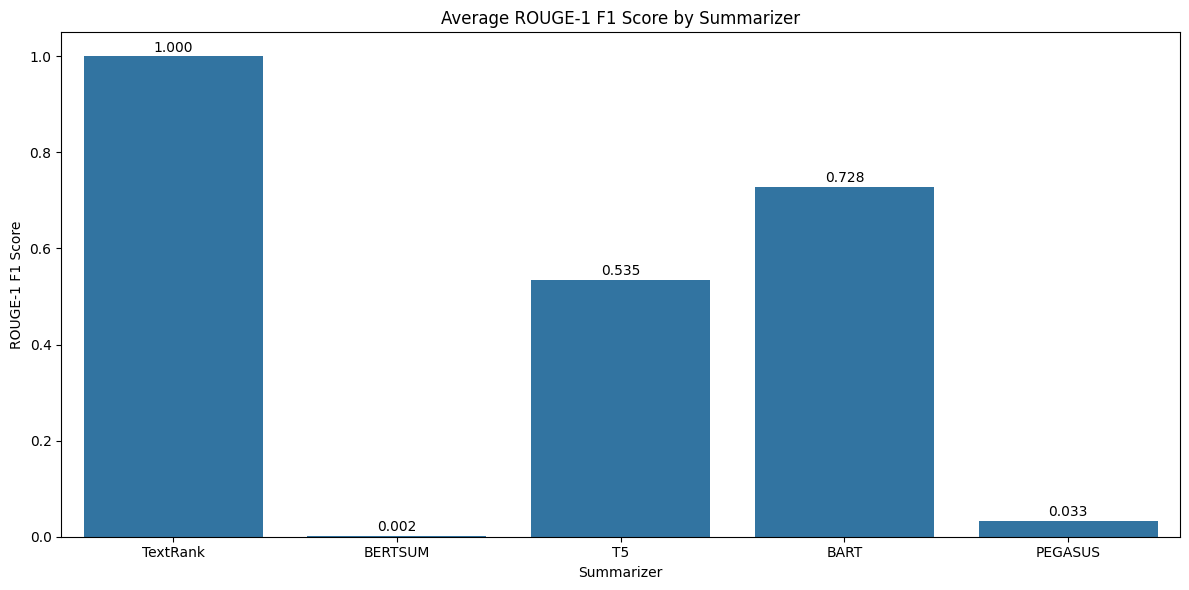

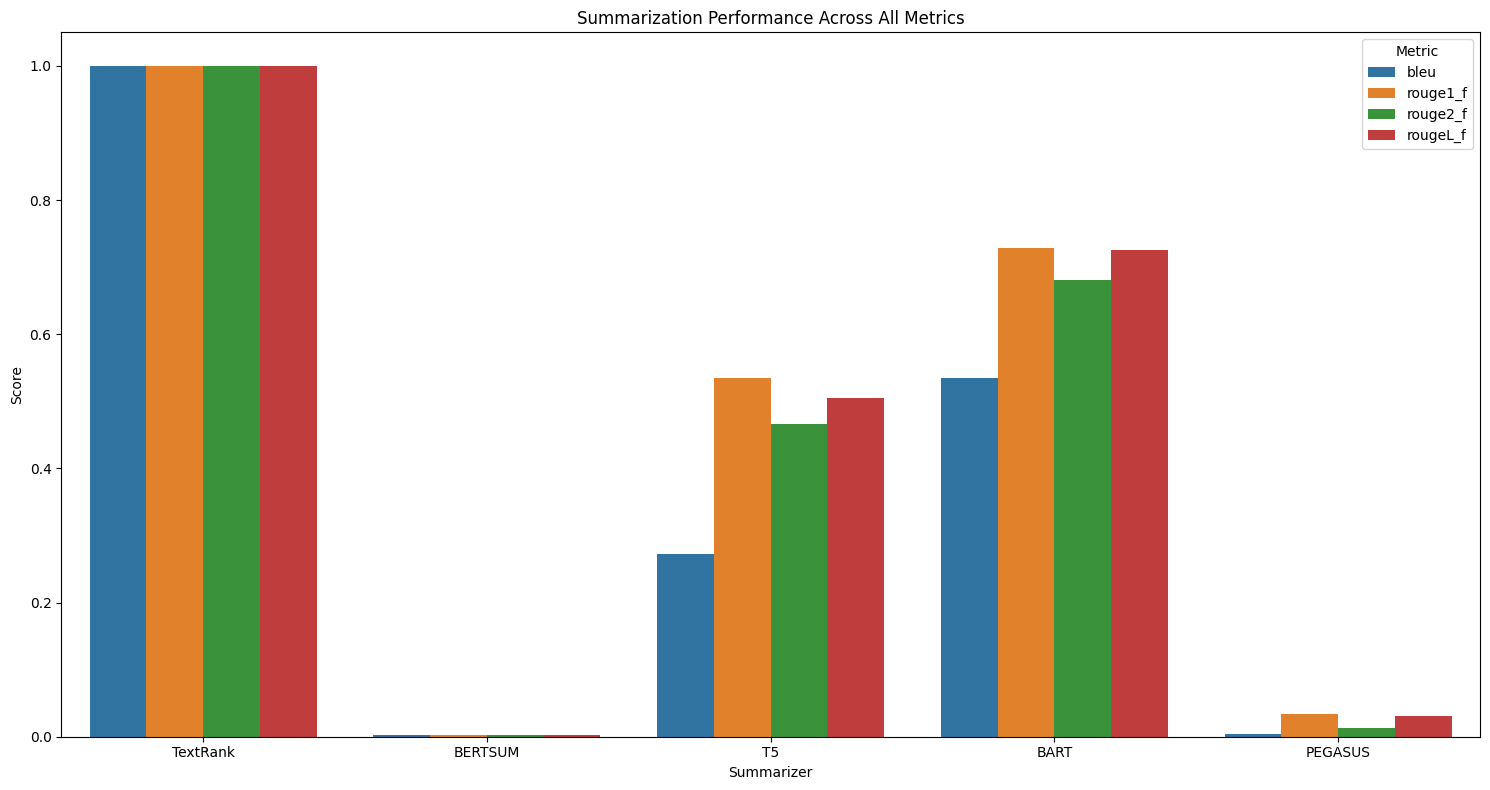

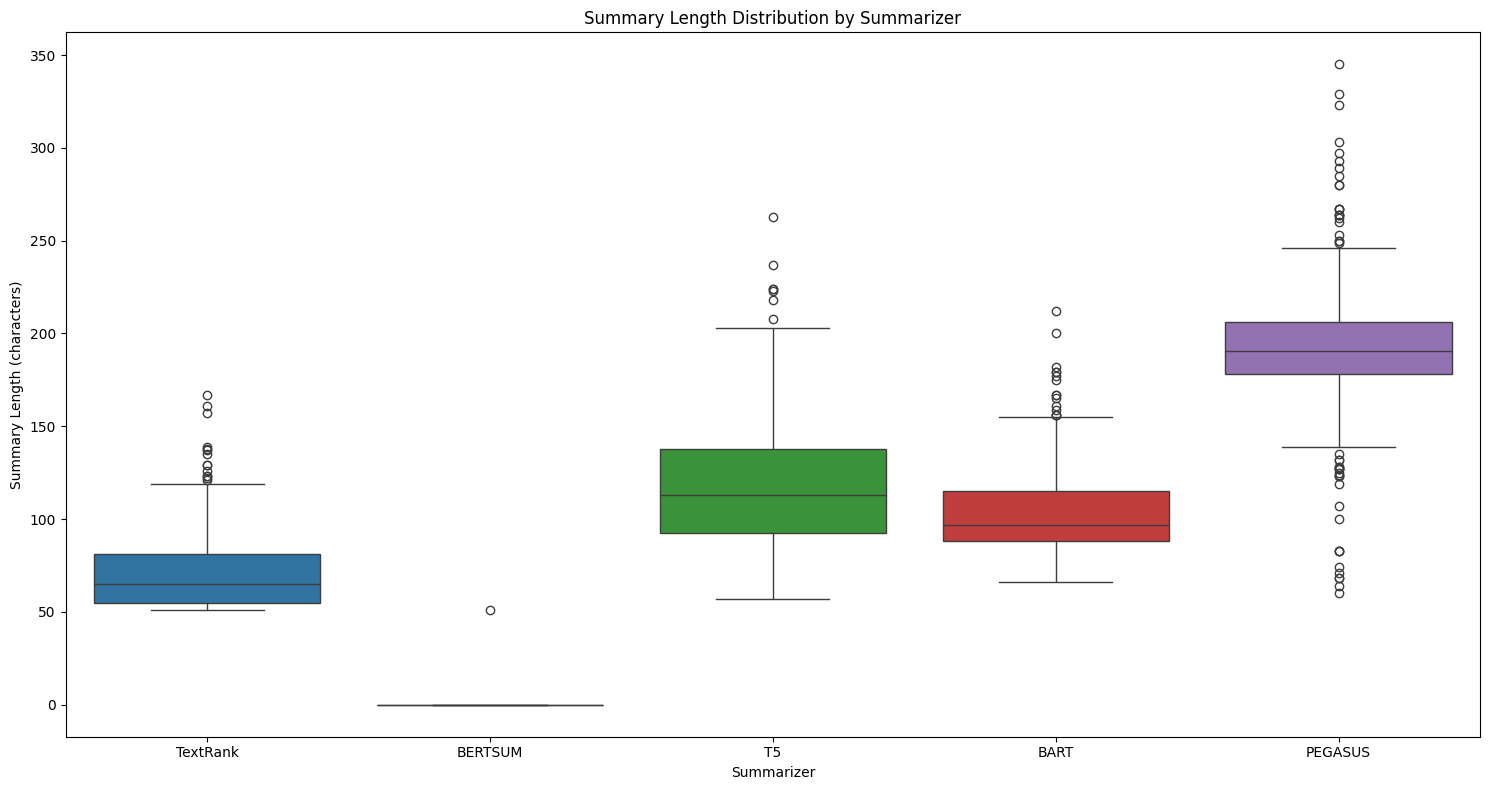

Average Performance Metrics:
            bleu  rouge1_f  rouge2_f  rougeL_f
TextRank  1.0000    1.0000    1.0000    1.0000
BERTSUM   0.0020    0.0020    0.0020    0.0020
T5        0.2717    0.5353    0.4655    0.5054
BART      0.5349    0.7284    0.6801    0.7262
PEGASUS   0.0041    0.0332    0.0129    0.0316

Step 4: Preparing models for Streamlit deployment...
Model configuration saved to /content/models/model_config.pkl
README for Streamlit app created at /content/models/README.md

Summarization pipeline completed!


In [15]:
# Part 8: Run the Complete Pipeline
# ===============================================================

def run_summarization_pipeline(file_path, nrows=1000, sample_size=100, save_dir='models'):
    """
    Run the complete summarization pipeline

    Args:
        file_path: Path to the CSV file
        nrows: Number of rows to load from the dataset
        sample_size: Number of samples to process for summarization
        save_dir: Directory to save models and results

    Returns:
        DataFrame with summarization results
    """
    # Step 1: Load and prepare data
    print("Step 1: Loading and preparing data...")
    data_df = load_and_prepare_data(file_path, nrows=nrows)

    # Step 2: Generate and evaluate summaries
    print("\nStep 2: Generating and evaluating summaries...")
    results_df = generate_and_evaluate_summaries(
        data_df, sample_size=sample_size, save_dir=save_dir
    )

    # Step 3: Analyze results
    print("\nStep 3: Analyzing results...")
    scores_df = analyze_summarization_results(results_df)

    # Step 4: Prepare models for Streamlit
    print("\nStep 4: Preparing models for Streamlit deployment...")
    prepare_models_for_streamlit(save_dir=save_dir)

    print("\nSummarization pipeline completed!")
    return results_df

# Main execution
if __name__ == "__main__":
    # Set the paths and parameters
    file_path = '/content/mimic3d.csv'  # Path to your CSV file
    models_dir = '/content/models'  # Directory to save models

    # Create the models directory
    os.makedirs(models_dir, exist_ok=True)

    # Run the pipeline
    # Note: Using small sample sizes for testing; increase for production
    results_df = run_summarization_pipeline(
        file_path=file_path,
        nrows=5000,  # Number of rows to load from the dataset
        sample_size=500,  # Number of samples to process for summarization
        save_dir=models_dir
    )